<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 5: Spatial autocorrelation</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Instructor: Michael Szell</h3>
</div>

# Source
This notebook was adapted from:
* A course on Geographic Data Science: https://darribas.org/gds_course/content/bF/lab_F.html

## 空间自相关和探索性空间数据分析

空间自相关与数据集中观察值的相似性与这些观察值的位置的相似性的程度有关。与传统的两个变量之间的相关关系（告知我们一个变量的值如何作为另一个变量的函数而变化）以及与它的时间序列对应物（将一个变量在某一特定时间点的值与以前的值联系起来）不完全一样，空间自相关将感兴趣的变量在一个特定地点的值与同一变量在周围地点的值联系起来。

这方面的一个关键概念是空间随机性：在这种情况下，观察的位置没有提供关于其价值的任何信息。换句话说，如果一个变量在空间上的分布没有明显的模式，那么它就是空间随机的。因此，空间自相关可以被正式定义为 "没有空间随机性"，这就为两类主要的自相关提供了空间，类似于传统的情况。*正*空间自相关，当类似的值倾向于聚集在类似的位置时；和*负*空间自相关，在类似的值倾向于分散和彼此之间的距离。

在本节课中，我们将学习如何在一个给定的数据集中探索空间自相关，询问数据的存在、性质和强度。为了做到这一点，我们将使用一套工具，统称为探索性空间数据分析（ESDA），专门为此目的而设计。ESDA方法的范围非常广泛，从不太复杂的方法，如折线图和一般的表格查询，到更先进和强大的方法，包括统计推理和对数据的地理维度的明确认识。本次会议的目的是让我们涉足后一组。

ESDA技术通常分为两大类：分析*全球*和*本地*空间自相关的工具。前者考虑数值位置所遵循的总体趋势，并对数据集中的*群集程度做出可能的陈述。*数值在地理分布上是否普遍遵循一种特定的模式*？*类似的数值与其他类似的数值是否比我们从纯粹的机会中预期的更接近？我们将通过使用Moran's I统计学来练习全局空间自相关。

局部*空间自相关的工具则侧重于空间不稳定性：地图的部分区域偏离总体趋势。这里的意思是，即使在空间关联的性质和强度方面，数据有一个特定的趋势，但一些特定的地区可以与一般模式有相当大的差异。不管数值的总体集中程度如何，我们可以观察到靠近其他高（低）值的小块异常高（低）值，我们称之为热（冷）点。此外，也有可能观察到一些被低（高）值包围的高（低）值，我们将命名这些为 "空间异常值"。本节课我们将回顾探讨局部空间自相关的主要技术是局部空间关联指标（LISA）。

In [1]:
import seaborn as sns
import pandas as pd
import esda
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt

d:\work\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data

在这次会议上，我们将使用2016年公投中离开欧盟的投票结果，在地方当局层面。特别是，我们将专注于投票离开的空间分布，最终获胜。从技术角度看，你将与多边形打交道，这些多边形上有一个数值（投票给脱欧的选民的百分比）。

为方便起见，所有必要的数据都被汇集到一个文件中，其中包含英格兰、威尔士和苏格兰每个地方当局的地理信息，以及投票属性。该文件采用地理空间格式[GeoPackage](http://www.geopackage.org/)，与更传统的shapefile相比有几个优点（其中主要是需要一个文件而不是几个）。该文件可从课程网站下载。

In [2]:
# Read the file in
br = gpd.read_file("files/brexit.gpkg")

In [3]:
br.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

现在，让我们在地方当局的ID上建立索引，同时将这些ID也保留为一列。

In [4]:
# Index table on the LAD ID
br = br.set_index("lad16cd", drop=False)
# Display summary
br.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000024
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16cd    380 non-null    object  
 2   lad16nm    380 non-null    object  
 3   Pct_Leave  380 non-null    float64 
 4   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 17.8+ KB


## 准备数据

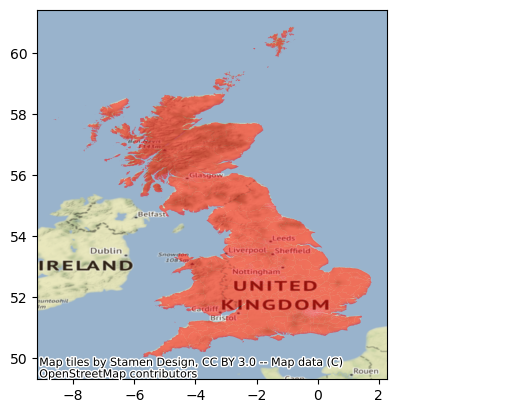

In [5]:
# Plot polygons
ax = br.plot(alpha=0.5, color='red');
# Add background map, expressing target CRS so the basemap can be reprojected
ctx.add_basemap(ax, crs=br.crs)

### 空间权重矩阵

正如前面所讨论的，空间权重矩阵是将地理空间正式编码为数字形式的方式，因此它很容易被计算机（或统计方法）理解。我们已经看到了许多可以定义空间权重矩阵的概念性方式，如毗连性、基于距离或区块。

在这个例子中，我们将展示如何建立一个queen毗连矩阵，它认为如果两个观测值至少有一个共同的边界点，那么它们就是邻居。换句话说，数据集中的一对地方当局要想在这个$W$下被认为是邻居，它们需要共享边界，或者换句话说，在某种程度上`接触`对方。

从技术上讲，我们将以与上次相同的方式建立毗连矩阵。我们将从`GeoDataFrame`开始，并将其传递给 `PySAL`中的女王毗连权重生成器（`ps.weights.Queen.from_dataframe`）。我们还将确保我们的数据表之前是以地方当局代码为索引的，因此$W$也是以该表格为索引的。

In [6]:
# Create the spatial weights matrix
%time w = weights.Queen.from_dataframe(br, idVariable="lad16cd")

CPU times: total: 609 ms
Wall time: 1.4 s


d:\work\miniconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: E06000046, E06000053, S12000013, S12000023, S12000027, W06000001.
  warnings.warn(message)


现在，我们拥有的`w`对象与我们过去创建的任何其他对象属于同一类型。因此，我们可以以相同的方式检查它。例如，我们可以检查谁是观察点`E08000012`的邻居：

In [7]:
w['E08000012']

{'E08000011': 1.0, 'E08000014': 1.0, 'E06000006': 1.0}

然而，我们计算$W$的单元格返回了一个关于 "岛屿 "的警告。请记住，这些岛屿不一定是地理意义上的（尽管其中一些会是），而是数学意义上的：不与任何其他国家共享边界的地方当局，因此没有任何邻居。我们可以对它们进行检查并绘制地图，以更好地了解我们正在处理的问题。

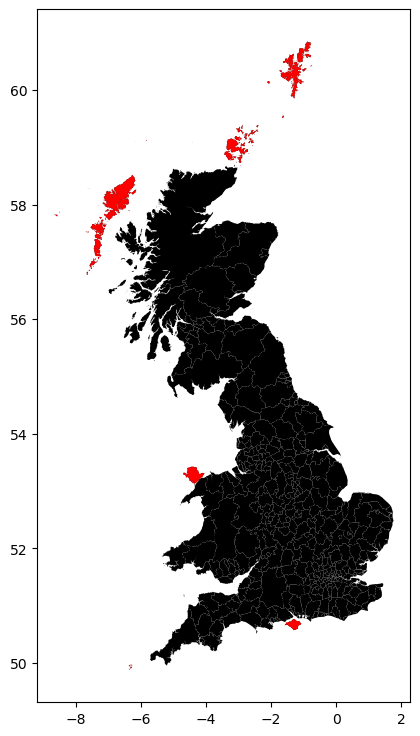

In [8]:
ax = br.plot(color='k', figsize=(9, 9))
br.loc[w.islands, :].plot(color='red', ax=ax);

在这种情况下，所有的岛屿确实都是“真正的”岛屿。这些情况可能会在分析中产生问题并扭曲结果。这种情况有几种解决方案，例如通过不同的标准（例如最近邻）将岛屿连接到其他观测值，然后组合两个空间权重矩阵。为方便起见，我们将从数据集中删除它们，因为它们是一个小样本，并且它们的删除可能不会对计算产生很大影响。

从技术上讲，这相当于一个子集，非常像我们在课程的前几周看到的，尽管在这种情况下我们将使用`drop`命令，该命令在这些情况下非常方便：

In [9]:
br = br.drop(w.islands)

一旦我们有了一组不是孤岛的地方当局，我们需要重新计算权重矩阵：

In [10]:
# Create the spatial weights matrix
# NOTE: this might take a few minutes as the geometries are
#       are very detailed
%time w = weights.Queen.from_dataframe(br, idVariable="lad16cd")

CPU times: total: 375 ms
Wall time: 1.12 s


最后，让我们对它进行行标准化，以确保矩阵的每一行总和为一：

In [11]:
# Row standardize the matrix
w.transform = 'R'

现在，由于我们已经对它们进行了行标准化，因此赋予三个邻居中每个邻居的权重都是 0.33，加起来就是一个。

In [12]:
w['E08000012']

{'E08000011': 0.3333333333333333,
 'E08000014': 0.3333333333333333,
 'E06000006': 0.3333333333333333}

#### 可视化空间权重（连通性图）

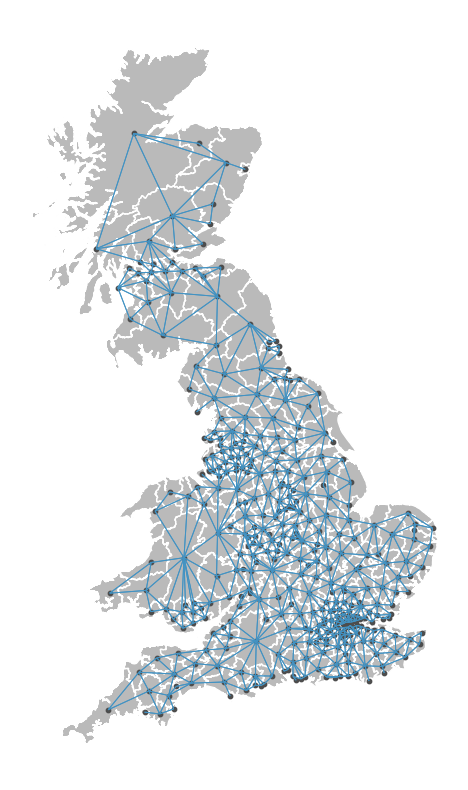

In [13]:
plot_spatial_weights(w, br.to_crs(epsg=27700), indexed_on="lad16cd"); # Use the British National Grid, 27700

### 空间滞后

一旦我们准备好了数据和空间权重矩阵，我们就可以开始计算离开欧盟的选票百分比的空间滞后。请记住，空间滞后是空间权重矩阵和给定变量的乘积，如果 $W$ 是行标准化的，则结果等于每个观测值邻域中变量的平均值。

我们可以计算变量 `Pct_Leave` 的空间滞后，并使用以下代码行将其直接存储在主表中：

In [14]:
br['w_Pct_Leave'] = weights.lag_spatial(w, br['Pct_Leave'])

让我们快速浏览一下结果变量，与原始变量相比：

In [15]:
br[['lad16cd', 'Pct_Leave', 'w_Pct_Leave']].head()

,lad16cd,Pct_Leave,w_Pct_Leave
lad16cd,,,
E06000001,E06000001,69.57,59.640000
E06000002,E06000002,65.48,60.526667
E06000003,E06000003,66.19,60.376667
E06000004,E06000004,61.73,60.488000
E06000005,E06000005,56.18,57.430000


解释空间滞后（`w_Pct_Leave`）的方式如下：哈特尔浦，69.6%的选民投票离开，被邻近的地方当局包围，平均而言，近60%的选民也投票离开欧盟。为了便于说明，我们实际上可以通过查询空间权重矩阵来找出 Hartepool 的邻居来检查这是否正确：

In [16]:
w.neighbors['E06000001']

['E06000004', 'E06000047']

然后检查它们的值：

In [17]:
neis = br.loc[w.neighbors['E06000001'], 'Pct_Leave']
neis

lad16cd
E06000004    61.73
E06000047    57.55
Name: Pct_Leave, dtype: float64

我们在空间滞后中看到的平均值是 61.8，可以计算如下：

In [18]:
neis.mean()

59.64

对于我们将在下面看到的一些技术，使用变量的标准化版本而不是原始版本操作更有意义。标准化是指减去平均值并除以列的每个观测值的标准偏差。这可以通过 Python 中的一些基本代数轻松完成：

In [19]:
br['Pct_Leave_std'] = (
    br['Pct_Leave'] - br['Pct_Leave'].mean()
) / br['Pct_Leave'].std()

最后，为了能够探索标准化值（有时也称为 $z$ 值）的空间模式，我们需要创建其空间滞后：

In [20]:
br['w_Pct_Leave_std'] = weights.lag_spatial(w, br['Pct_Leave_std'])

## 全局空间自相关

全球空间自相关与数据中存在的整体地理模式相关。因此，旨在衡量这一趋势的统计数据根据地图的聚类程度来表征地图并对其进行汇总。此摘要可以是视觉的，也可以是数字的。在本节中，我们将逐一介绍它们的示例：莫兰图和莫兰空间自相关 I 统计量。

### 莫兰图

莫兰图是一种可视化空间数据集以探索空间自相关的性质和强度的方法。它本质上是一个传统的散点图，其中感兴趣的变量根据其空间滞后显示。为了能够解释高于或低于平均值的值，以及它们以标准差为单位的数量，通常通过减去其平均值并将其除以其标准差来标准化感兴趣的变量。

从技术上讲，创建莫兰图与在 Python 中创建任何其他散点图非常相似，前提是我们已经标准化了变量并事先计算了它的空间滞后：

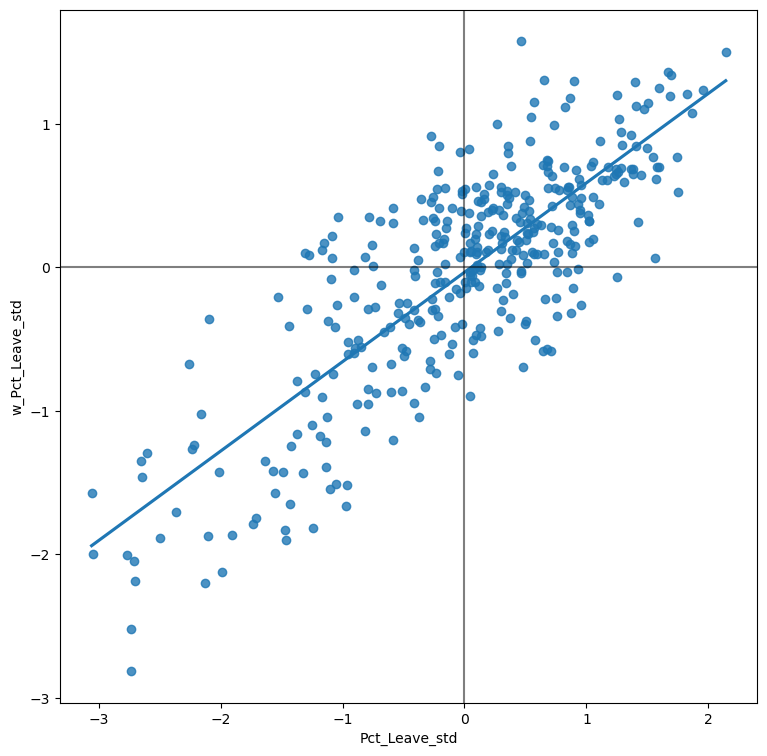

In [21]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

上图显示了投票离开欧盟的标准化百分比（`Pct_Leave_std`）与其空间滞后之间的关系，由于使用的$W$是行标准化的，可以解释为在特定地方当局的周边地区投票离开的平均百分比。为了指导对该图的解释，帖子中还包括一条线性拟合。这条线代表了对散点图的最佳线性拟合，或者换句话说，用一条直线来表示两个变量之间关系的最佳方式。

该图显示了两个变量之间的正向关系。这与*正*的空间自相关的存在有关：类似的值往往位于彼此之间的附近。这意味着*总体趋势是高值接近其他高值，而低值被其他低值包围。然而，这并不意味着这是数据集中的唯一情况：当然，也可能存在高值被低值包围的特殊情况，反之亦然。但这意味着，如果我们必须用相似值的聚集程度来总结数据的主要模式，最好的方法是说它们是正相关的，因此在空间上是聚集的。

在这个例子的背景下，这可以被解释为：地方当局在欧盟公投中的投票方式显示出正的空间自相关。这意味着拥有高比例脱欧选民的地方当局往往位于其他地方当局附近，而这些地方当局也有相当份额的选民投票支持脱欧，反之亦然。

### Moran's I

莫兰图是探索数据的一个很好的工具，可以很好地了解数值在空间上的聚集程度。然而，由于它是一个图形装置，有时很难将其见解浓缩到一个更简洁的方式中。对于这些情况，一个好的方法是想出一个统计措施来总结这个数字。这正是Moran's I所要做的。

与均值在非空间环境中总结数值分布的关键因素一样，莫兰氏I在空间数据集中也是如此。继续比较，我们可以把平均值看作是总结直方图或核密度图的一个单一数值。同样，Moran's I也抓住了Moran图的大部分本质。事实上，两者之间甚至有密切的联系：Moran's I的值与Moran Plot上面覆盖的线性拟合的斜率相对应。

为了在我们的数据集中计算Moran's I，我们可以直接调用`PySAL`中的一个特定函数。

In [22]:
mi = esda.Moran(br['Pct_Leave'], w)

请注意，在这种情况下，我们不需要使用标准化版本，因为我们不会直观地表示它。

方法`ps.Moran`创建一个对象，其中包含比实际统计数据多得多的信息。如果我们想检索统计数据的值，我们可以这样做：

In [23]:
mi.I

0.6228641407137806

我们将从Moran的I中提取的另一点信息与统计推断有关：我们在地图和Moran的I捕获的值中观察到的模式是由完全随机的过程生成的概率有多大？如果我们考虑相同的变量，但随机洗牌其位置，我们会得到具有相似特征的地图吗？

计算此值的机制的具体细节超出了会话的范围，但重要的是要知道，与地图的莫兰 I 相关的足够小的 p 值允许拒绝地图是随机的假设。换句话说，我们可以得出结论，如果值被随机分配到特定位置，地图显示的空间模式比我们预期的更多。

Moran's I 最可靠的 p 值可以在属性 `p_sim` 中找到：

In [24]:
mi.p_sim

0.001

这只是0.1%，按照标准术语，它将被认为是具有统计意义的。我们可以快速阐述它的直觉。0.001（或0.1%）意味着，如果我们生成大量具有相同值但在空间上随机分配的地图，并计算每个地图的Moran's I统计量，其中只有0.1%的地图显示比我们从真实数据中获得的值更大（绝对）值，而其他99.9%的随机地图将获得较小的（绝对）Moran's I值。如果我们再次记住，莫兰的I的值也可以解释为莫兰图的斜率，那么在这种情况下，脱欧投票值的特定空间排列比完全空间随机过程分配的值更集中，因此具有统计意义。


一旦我们计算了Moran的I并创建了一个像`mi`这样的对象，我们就可以使用`splot`中的一些功能来更轻松地复制上面的图：

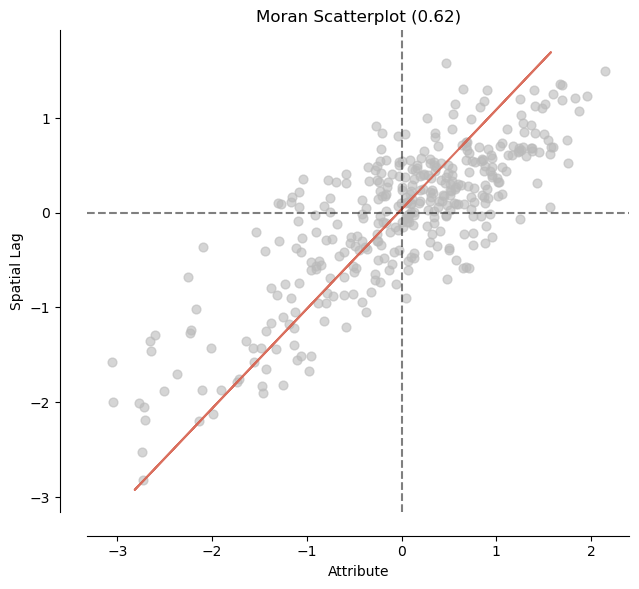

In [25]:
moran_scatterplot(mi);

d:\work\miniconda3\lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


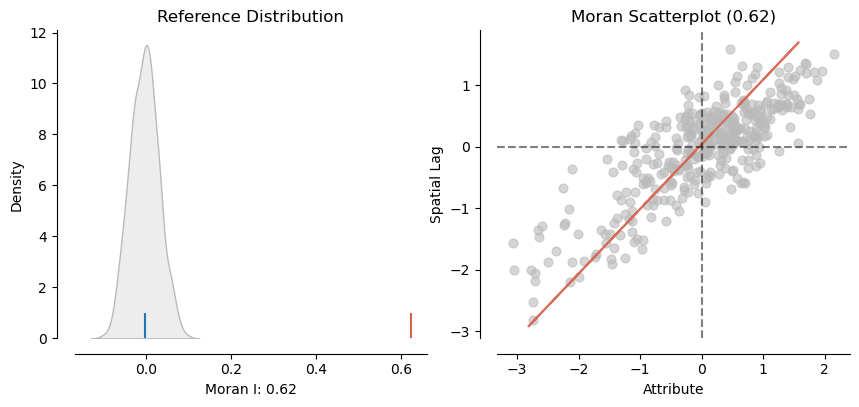

In [26]:
plot_moran(mi);

作为第一步，全局自相关分析可以告诉我们，观测值似乎在空间上确实呈正相关。就我们最初的目标是在对英国脱欧的态度中找到空间结构而言，这种观点似乎是一致的：如果投票没有这样的结构，它不应该在空间上显示一种模式——从技术上讲，它会显示一个随机的模式。

## 局部空间自相关

Moran的I是一个很好的工具，可以将数据集汇总为单个值，告知其*聚类*程度。但是，标识地图中特定值所在的区域并不是适当的度量。换句话说，Moran的我可以告诉我们值总体上是聚类的，但它不会告诉我们聚类在哪里。为此，我们需要使用空间自相关的*局部*度量。局部度量考虑数据集中的每个单个观测值，并像*全局*度量值一样对整体数据进行操作。正因为如此，它们不擅长总结地图，但它们允许获得进一步的洞察力。

在本节中，我们将考虑[空间关联的地方指标](http://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.1995.tb00338.x/abstract)（LISA），这是莫兰I等全球措施的局部对应物。这些方法的核心是将数据集中的观测值分为从莫兰图派生的四组：高值包围的高值 （HH）、其他低值 （LL） 附近的低值、低值中的高值 （HL） 和 viceversa （LH）。这些组中的每一个通常称为“象限”。下面可以看到这些组中每个群体落入莫兰图的插图：

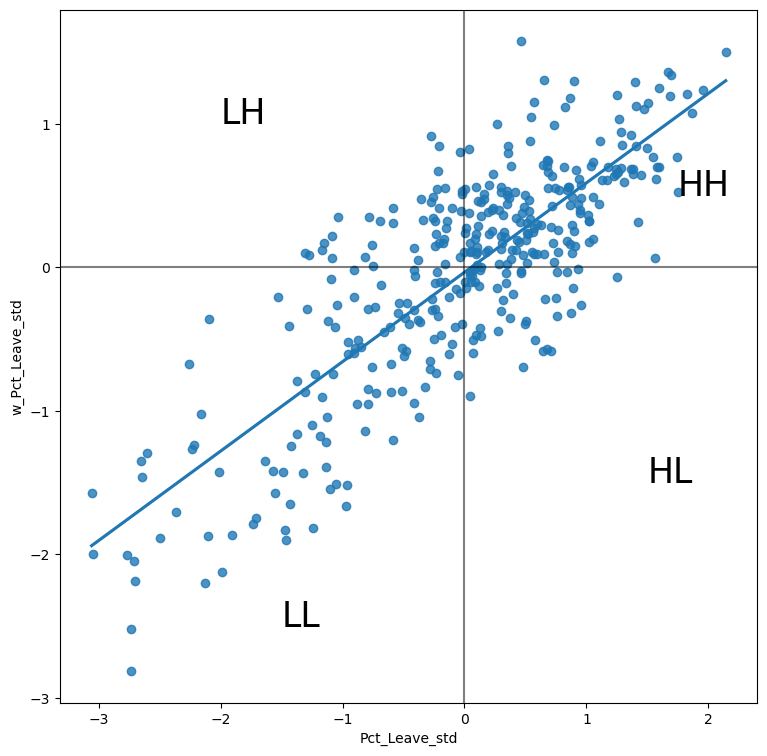

In [27]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1.5, -2.5, "LL", fontsize=25)
# Display
plt.show()

到目前为止，我们已经根据数据集中的每个观测值和其邻居的观测值对其进行了分类。这只是确定数值异常集中区域的一半方法。为了知道每个位置是否是一个*统计意义上的*给定的集群，我们又需要把它与我们在数据完全随机分配的情况下所期望的进行比较。毕竟，根据定义，根据上面的比较，每一个观察都会是一种类型的。然而，我们感兴趣的是，这些数值集中的强度是否异常高。

这正是LISA的设计目的。如前所述，对其统计学基础的更详细描述超出了本文的范围，但我们将尝试对其如何进行的直觉进行一些说明。其核心思想是识别这样的情况，即一个观察值与它的邻居的平均值之间的比较比我们从纯粹的机会中预期的更相似（HH，LL）或不相似（HL，LH）。做到这一点的机制类似于全球莫兰氏I中的机制，但在这种情况下适用于每个观察，然后产生与原始观察一样多的统计数据。

LISA被广泛用于许多领域，以确定空间中的数值集群。它们是一个非常有用的工具，可以快速返回数值集中的区域，并提供关于可能发生作用的过程的*暗示性证据。因此，它们在探索性工具箱中具有重要地位。LISAs有用的例子包括：识别区域内贫困的空间集群，检测种族飞地，划分任何现象的特别高/低活动区域，等等。

在Python中，由于`PySAL`的存在，我们可以用非常简化的方式计算LISAs。



In [28]:
lisa = esda.Moran_Local(br['Pct_Leave'], w)

我们需要传递的是感兴趣的变量--离开投票的百分比--和描述构成数据集的不同观察点之间的邻接关系的空间权重。

由于其本身的性质，看LISA的数字结果并不总是利用它们所能提供的所有信息的最有用的方法。请记住，我们正在为数据中的每一个特征观测值计算一个统计量，因此，如果我们有许多这样的观测值，就很难提取任何有意义的模式。相反，通常要做的是创建一张地图，也就是通常所说的聚类图，提取出重要的观测值（那些极不可能来自于纯粹的机会的观测值），并根据它们的象限类别用特定的颜色绘制出来。

所有需要的部分都包含在我们上面创建的`lisa`对象中。但是，为了使地图的制作更加直接，我们可以把它们拉出来，插入到主数据表中，`br`。

In [29]:
# Break observations into significant or not
br['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
br['quadrant'] = lisa.q

In [30]:
br['quadrant']

lad16cd
E06000001    1
E06000002    1
E06000003    1
E06000004    1
E06000005    1
            ..
W06000020    1
W06000021    2
W06000022    4
W06000023    1
W06000024    1
Name: quadrant, Length: 374, dtype: int32

让我们在这两个步骤上停下来。首先，`significant`列。与全局Moran's I类似，`PySAL`自动计算每个LISA的p值。因为不是每个观测值都代表一个统计显著的观测值，所以我们想要识别那些p值足够小的观察值，排除从纯粹偶然中获得类似情况的可能性。遵循与全球Moran's I类似的推理，我们选择5%作为统计显著性的阈值。为了识别这些值，我们创建一个变量`significant`，如果观测值的 p 值满足条件，则包含`True`，否则包含`False`。我们可以检查一下情况：

In [31]:
br['significant'].head()

lad16cd
E06000001    False
E06000002    False
E06000003    False
E06000004    False
E06000005    False
Name: significant, dtype: bool

前五个 p 值可以通过以下方式检查：

In [32]:
lisa.p_sim[:5]

array([0.191, 0.113, 0.117, 0.057, 0.229])

请注意第三个和第四个如何小于 0.05，因为变量`significant`正确标识。

其次，每个观测值所属的象限。这个更容易，因为它直接内置到`lisa`对象中：

In [33]:
br['quadrant'].head()

lad16cd
E06000001    1
E06000002    1
E06000003    1
E06000004    1
E06000005    1
Name: quadrant, dtype: int32

变量中的数字与实际象限之间的对应关系如下：

* 1: HH
* 2: LH
* 3: LL
* 4: HL

有了这两个元素，`significant`和 `quadrant`，我们可以构建一个典型的 LISA 集群映射，将映射技能与我们学到的关于子集化和查询表的知识结合起来：

我们可以创建一个带有`splot`的快速 LISA 集群映射：

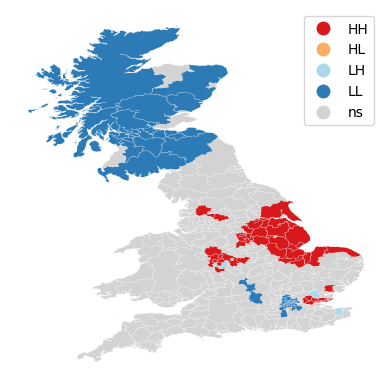

In [34]:
lisa_cluster(lisa, br);

或者，如果我们想更好地控制显示的内容以及每个组件的呈现方式，我们可以自己编辑画图：

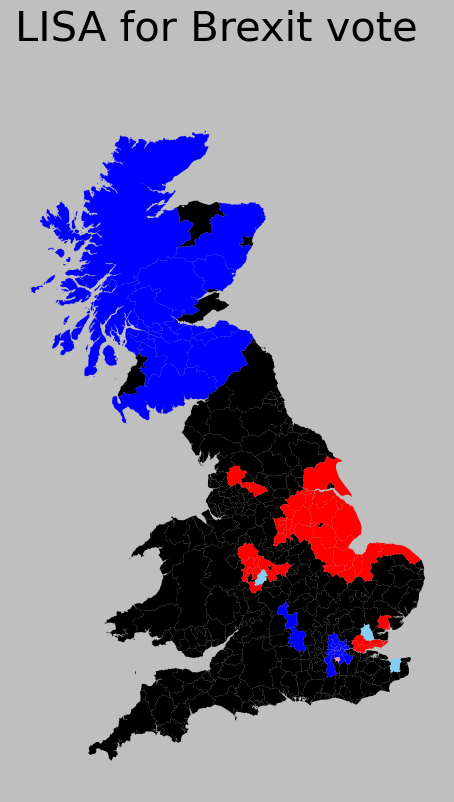

In [35]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot insignificant clusters
ns = br.loc[br['significant']==False, 'geometry']
ns.plot(ax=ax, color='k')
# Plot HH clusters
hh = br.loc[(br['quadrant']==1) & (br['significant']==True), 'geometry']
hh.plot(ax=ax, color='red')
# Plot LL clusters
ll = br.loc[(br['quadrant']==3) & (br['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue')
# Plot LH clusters
lh = br.loc[(br['quadrant']==2) & (br['significant']==True), 'geometry']
lh.plot(ax=ax, color='#83cef4')
# Plot HL clusters
hl = br.loc[(br['quadrant']==4) & (br['significant']==True), 'geometry']
hl.plot(ax=ax, color='#e59696')
# Style and draw
f.suptitle('LISA for Brexit vote', size=30)
f.set_facecolor('0.75')
ax.set_axis_off()
plt.show()

上图显示了LISA对英国脱欧投票的结果。在鲜红色的部分，我们发现那些高脱欧选民异常集中的地方当局，其周围也有高水平的脱欧投票。这与英格兰东部、黑区和伦敦东部的地区相对应。在浅红色的区域，我们发现了第一类*空间异常值。这些地区拥有较高的脱欧投票率，但周围是支持离开欧盟的低支持率地区（例如伦敦市中心）。最后，在浅蓝色中我们发现了另一种类型的空间离群点：脱欧支持率低的地方当局被其他高支持率的当局所包围。

对LISA地图的实质性解释需要将其输出与创建该地图的分析者的初衷联系起来。在这种情况下，我们最初的想法是探索支持离开欧盟的空间结构。在这种情况下，LISA被证明是一个相当有用的工具。对比上面的LISA地图和我们开始使用的正方形图，我们可以将LISA解释为正方形图中详细但可能过于复杂的图片的 "简化"，它将读者的注意力集中在显示出特别高的（不）相似值的区域，帮助投票的空间结构以一种更明确的方式出现。这样做的结果突出了英格兰东部和中部地区在投票支持脱欧方面的相关性，以及地图上对脱欧的兴奋度低很多的地区。


LISA 统计数据的结果可以连接到莫兰图，以可视化每种类型的面在散点图中的位置：

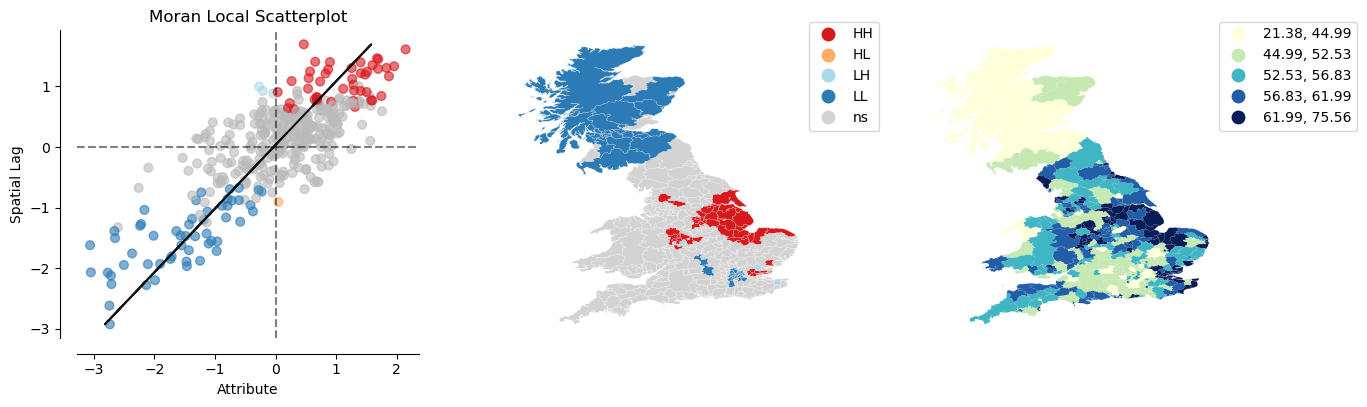

In [36]:
plot_local_autocorrelation(lisa, br, 'Pct_Leave');